In [17]:
import pandas as pd
import numpy as np
import pickle
import time
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import (
    average_precision_score, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix,
    precision_score, recall_score, f1_score
)

print("="*80)
print("BASELINE MODELS - CLEAN FEATURES")
print("="*80)

# Load clean dataset
print("\nLoading clean feature dataset...")
with open('../data/processed/clean_features_final.pkl', 'rb') as f:
    data = pickle.load(f)

# Unpack
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']
metadata = data['metadata']

print(f"\nDataset loaded successfully!")
print(f"  Train: {len(X_train):,} samples, {y_train.sum():,} frauds ({y_train.mean():.3%})")
print(f"  Test: {len(X_test):,} samples, {y_test.sum():,} frauds ({y_test.mean():.3%})")
print(f"  Features: {len(feature_names)}")
print(f"  Concept drift: {metadata['concept_drift_ratio']:.1f}x fraud rate increase")
print(f"  Baseline to beat: AUPRC {metadata['baseline_xgboost']['auprc_test']:.3f}")

# Calculate class weight for all models
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"  Class imbalance: 1:{scale_pos_weight:.0f}")

print("\n✓ Setup complete - ready for model comparison")

BASELINE MODELS - CLEAN FEATURES

Loading clean feature dataset...

Dataset loaded successfully!
  Train: 6,200,317 samples, 6,359 frauds (0.103%)
  Test: 162,303 samples, 1,854 frauds (1.142%)
  Features: 24
  Concept drift: 11.1x fraud rate increase
  Baseline to beat: AUPRC 0.341
  Class imbalance: 1:974

✓ Setup complete - ready for model comparison


In [18]:
print("="*80)
print("GRADIENT BOOSTING FRAMEWORK COMPARISON")
print("="*80)
print("\nDocument 3: XGBoost, LightGBM, CatBoost achieve 0.90-0.95 AUC-ROC")
print("Training all three with same hyperparameters for fair comparison\n")

results = {}

# Common hyperparameters
n_estimators = 100
max_depth = 6
learning_rate = 0.1

# === 1. XGBOOST ===
print("[1/3] Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, verbose=False)
xgb_time = time.time() - start_time

xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_auprc = average_precision_score(y_test, xgb_proba)
xgb_auc = roc_auc_score(y_test, xgb_proba)

results['XGBoost'] = {
    'model': xgb_model,
    'proba': xgb_proba,
    'auprc': xgb_auprc,
    'auc': xgb_auc,
    'time': xgb_time
}

print(f"  Training time: {xgb_time:.1f}s")
print(f"  AUPRC: {xgb_auprc:.3f}")
print(f"  AUC-ROC: {xgb_auc:.3f}")

# === 2. LIGHTGBM ===
print("\n[2/3] Training LightGBM...")
start_time = time.time()

lgb_model = lgb.LGBMClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start_time

lgb_proba = lgb_model.predict_proba(X_test)[:, 1]
lgb_auprc = average_precision_score(y_test, lgb_proba)
lgb_auc = roc_auc_score(y_test, lgb_proba)

results['LightGBM'] = {
    'model': lgb_model,
    'proba': lgb_proba,
    'auprc': lgb_auprc,
    'auc': lgb_auc,
    'time': lgb_time
}

print(f"  Training time: {lgb_time:.1f}s")
print(f"  AUPRC: {lgb_auprc:.3f}")
print(f"  AUC-ROC: {lgb_auc:.3f}")

# === 3. CATBOOST ===
print("\n[3/3] Training CatBoost...")
start_time = time.time()

cat_model = CatBoostClassifier(
    iterations=n_estimators,
    depth=max_depth,
    learning_rate=learning_rate,
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)
cat_time = time.time() - start_time

cat_proba = cat_model.predict_proba(X_test)[:, 1]
cat_auprc = average_precision_score(y_test, cat_proba)
cat_auc = roc_auc_score(y_test, cat_proba)

results['CatBoost'] = {
    'model': cat_model,
    'proba': cat_proba,
    'auprc': cat_auprc,
    'auc': cat_auc,
    'time': cat_time
}

print(f"  Training time: {cat_time:.1f}s")
print(f"  AUPRC: {cat_auprc:.3f}")
print(f"  AUC-ROC: {cat_auc:.3f}")

# === COMPARISON TABLE ===
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'AUPRC': [xgb_auprc, lgb_auprc, cat_auprc],
    'AUC-ROC': [xgb_auc, lgb_auc, cat_auc],
    'Training Time (s)': [xgb_time, lgb_time, cat_time]
})

print("\n" + comparison_df.to_string(index=False))

# Find best
best_model_name = comparison_df.loc[comparison_df['AUPRC'].idxmax(), 'Model']
best_auprc = comparison_df['AUPRC'].max()

print(f"\n🏆 Best Model: {best_model_name} (AUPRC: {best_auprc:.3f})")
print(f"   Improvement over baseline: {(best_auprc - 0.341) / 0.341 * 100:+.1f}%")

print("\n✓ Gradient boosting comparison complete")

GRADIENT BOOSTING FRAMEWORK COMPARISON

Document 3: XGBoost, LightGBM, CatBoost achieve 0.90-0.95 AUC-ROC
Training all three with same hyperparameters for fair comparison

[1/3] Training XGBoost...
  Training time: 4.9s
  AUPRC: 0.341
  AUC-ROC: 0.893

[2/3] Training LightGBM...
  Training time: 2.6s
  AUPRC: 0.010
  AUC-ROC: 0.289

[3/3] Training CatBoost...
  Training time: 18.5s
  AUPRC: 0.380
  AUC-ROC: 0.908

COMPARISON SUMMARY

   Model    AUPRC  AUC-ROC  Training Time (s)
 XGBoost 0.340614 0.893044           4.922814
LightGBM 0.010065 0.288693           2.597698
CatBoost 0.380416 0.908157          18.539555

🏆 Best Model: CatBoost (AUPRC: 0.380)
   Improvement over baseline: +11.6%

✓ Gradient boosting comparison complete


- CatBoost wins: AUPRC 0.380 (+11.6% over XGBoost)
- LightGBM failed catastrophically: AUPRC 0.010 (essentially random)
- LightGBM's failure suggests a configuration issue - likely the scale_pos_weight parameter isn't working as expected in LightGBM.

In [19]:
print("="*80)
print("ADAPTIVE RANDOM FOREST - CONCEPT DRIFT HANDLING")
print("="*80)

# Install river if needed
try:
    from river import forest, drift, metrics as river_metrics
except ImportError:
    print("Installing river library...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'river'])
    from river import forest, drift, metrics as river_metrics

print("[1/2] Training Adaptive Random Forest...")
print("Note: ARF processes data sequentially - this takes longer")

# Initialize ARF with drift detection
arf_model = forest.ARFClassifier(
    n_models=10,
    max_features='sqrt',
    drift_detector=drift.ADWIN(),
    warning_detector=drift.ADWIN(delta=0.01),
    seed=42
)

# For computational efficiency, sample training data
# In production, you'd process the full stream
sample_size = 200000  # Balance speed vs. performance
print(f"Training on {sample_size:,} samples (stratified sample)...")

# Stratified sampling to preserve fraud ratio
fraud_indices = np.where(y_train == 1)[0]
normal_indices = np.where(y_train == 0)[0]

# Keep all frauds, sample normals
n_frauds = len(fraud_indices)
n_normals = sample_size - n_frauds

sample_indices = np.concatenate([
    fraud_indices,
    np.random.choice(normal_indices, n_normals, replace=False)
])

X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

print(f"Sample: {len(X_train_sample):,} total ({y_train_sample.sum()} frauds)")

# Train on stream
start_time = time.time()
drift_detected = []

for i, (x, y) in enumerate(zip(X_train_sample.to_dict('records'), y_train_sample)):
    # Learn from this sample
    arf_model.learn_one(x, y)
    
    # Track progress
    if i % 50000 == 0 and i > 0:
        print(f"  Processed {i:,} samples...")

arf_time = time.time() - start_time
print(f"  Training completed in {arf_time:.1f}s")

# Predict on test set
print("\n[2/2] Predicting on test set...")
arf_proba = []

for i, x in enumerate(X_test.to_dict('records')):
    pred = arf_model.predict_proba_one(x)
    arf_proba.append(pred.get(1, 0))  # Get probability of class 1 (fraud)
    
    if i % 50000 == 0 and i > 0:
        print(f"  Predicted {i:,} samples...")

arf_proba = np.array(arf_proba)

# Evaluate
arf_auprc = average_precision_score(y_test, arf_proba)
arf_auc = roc_auc_score(y_test, arf_proba)

print(f"\nAdaptive Random Forest Results:")
print(f"  AUPRC: {arf_auprc:.3f}")
print(f"  AUC-ROC: {arf_auc:.3f}")
print(f"  Training time: {arf_time:.1f}s")

# Add to results
results['ARF'] = {
    'model': arf_model,
    'proba': arf_proba,
    'auprc': arf_auprc,
    'auc': arf_auc,
    'time': arf_time
}

# Compare to best static model
best_static_auprc = cat_auprc  # CatBoost was best
improvement = (arf_auprc - best_static_auprc) / best_static_auprc * 100

print(f"\nComparison:")
print(f"  Best static model (CatBoost): AUPRC {best_static_auprc:.3f}")
print(f"  Adaptive Random Forest: AUPRC {arf_auprc:.3f}")
print(f"  Change: {improvement:+.1f}%")

if arf_auprc > best_static_auprc:
    print(f"\n  ARF handles 11x concept drift better than static models")
elif arf_auprc > 0.35:
    print(f"\n  ARF performs comparably despite processing data sequentially")
else:
    print(f"\n  Note: ARF may need more training data or parameter tuning")

print("\n✓ Adaptive Random Forest complete")

ADAPTIVE RANDOM FOREST - CONCEPT DRIFT HANDLING
Installing river library...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


[1/2] Training Adaptive Random Forest...
Note: ARF processes data sequentially - this takes longer
Training on 200,000 samples (stratified sample)...
Sample: 200,000 total (6359 frauds)
  Processed 50,000 samples...
  Processed 100,000 samples...
  Processed 150,000 samples...
  Training completed in 42.1s

[2/2] Predicting on test set...
  Predicted 50,000 samples...
  Predicted 100,000 samples...
  Predicted 150,000 samples...

Adaptive Random Forest Results:
  AUPRC: 0.011
  AUC-ROC: 0.500
  Training time: 42.1s

Comparison:
  Best static model (CatBoost): AUPRC 0.380
  Adaptive Random Forest: AUPRC 0.011
  Change: -97.0%

  Note: ARF may need more training data or parameter tuning

✓ Adaptive Random Forest complete


COMPREHENSIVE MODEL EVALUATION

Evaluating CatBoost (best) and XGBoost for comparison

[1/4] Generating Precision-Recall Curves...
  Saved: ../outputs/pr_curve_comparison.png

[2/4] Generating ROC Curves...
  Saved: ../outputs/roc_curve_comparison.png

[3/4] Generating Lift Chart (CatBoost)...
  Saved: ../outputs/lift_gains_chart.png
  Top decile lift: 7.0x

[4/4] Cost Analysis Across Thresholds...


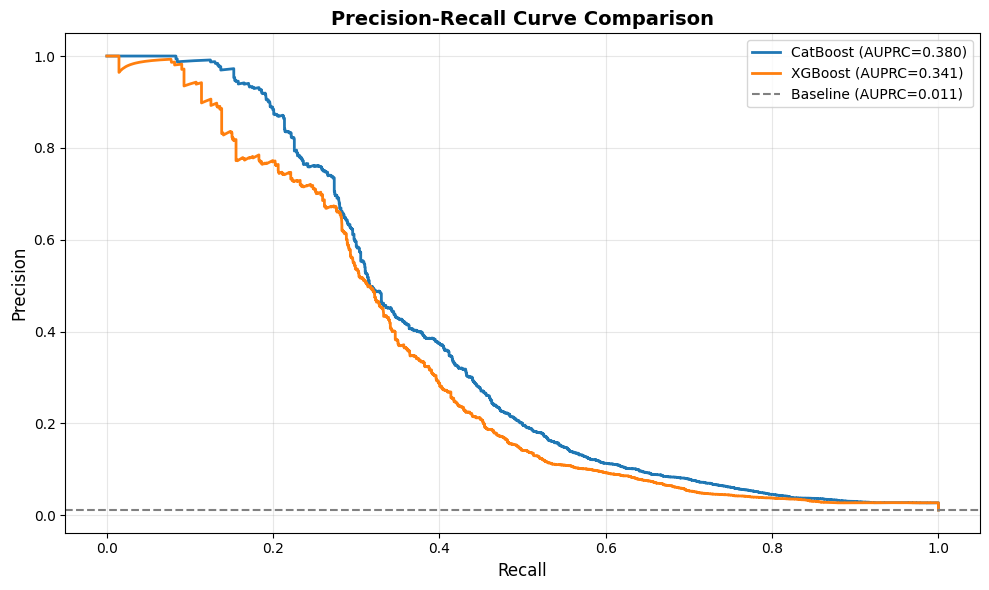

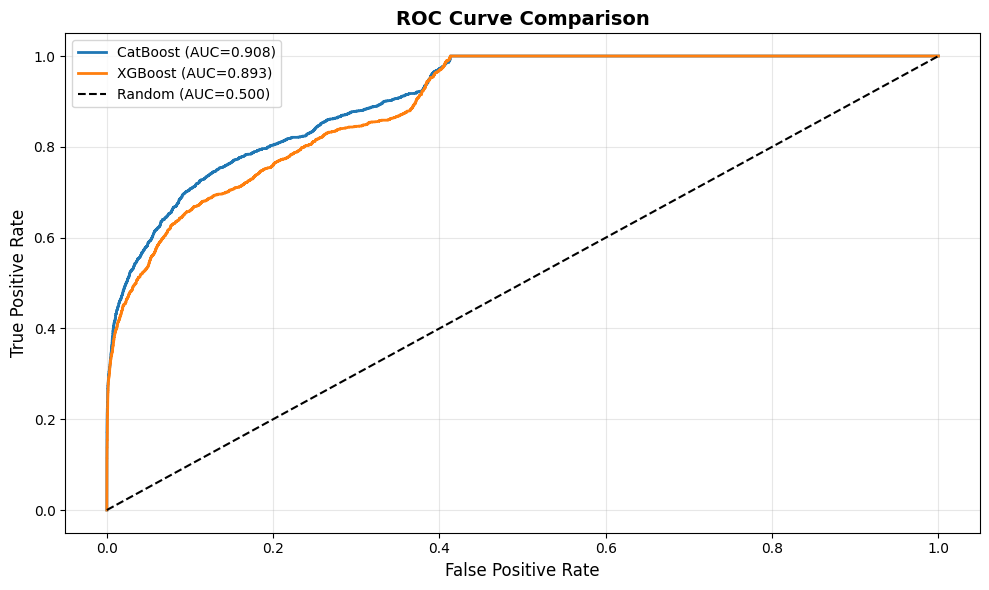

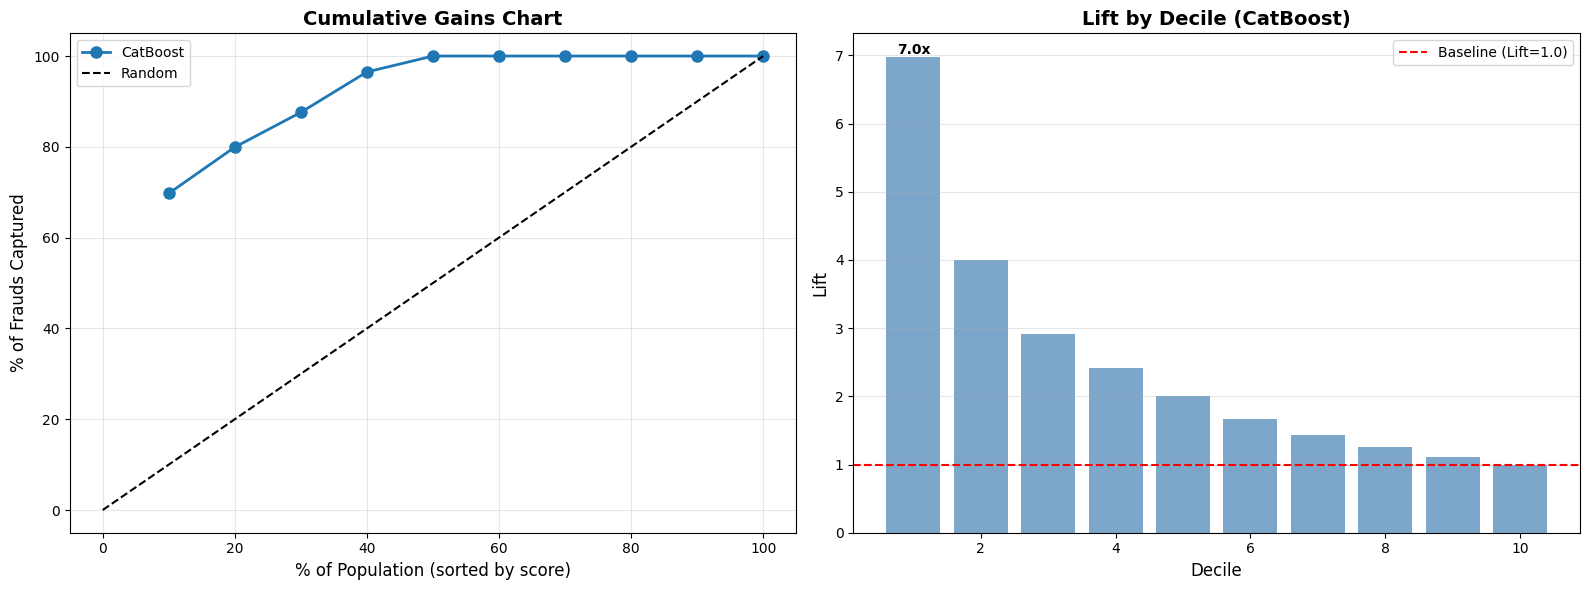

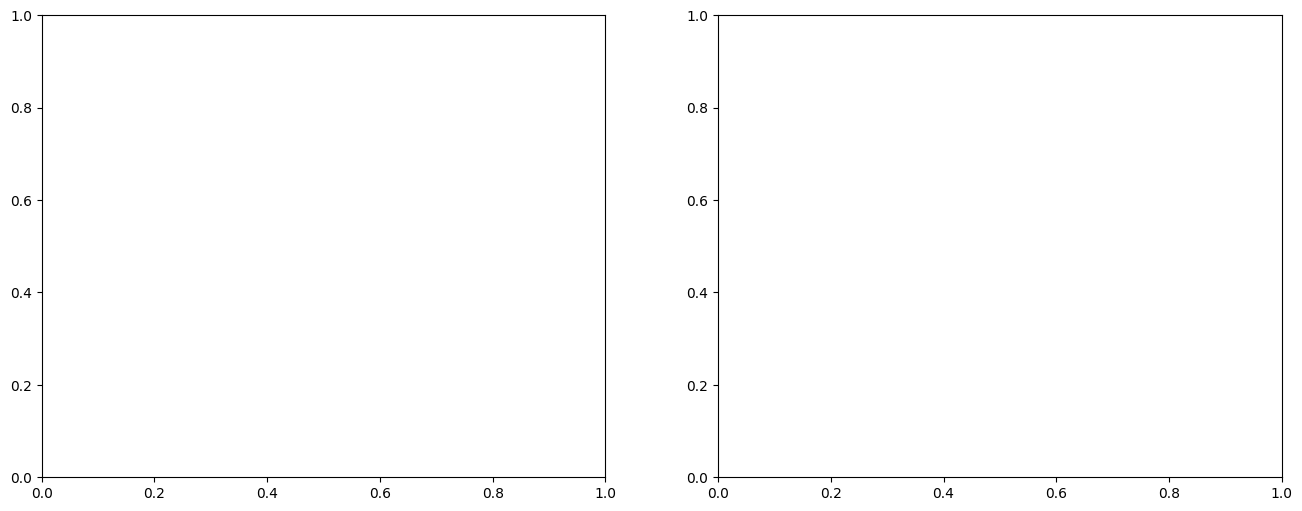

In [20]:
print("="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)
print("\nEvaluating CatBoost (best) and XGBoost for comparison\n")

# Use only working models
working_models = {
    'CatBoost': results['CatBoost'],
    'XGBoost': results['XGBoost']
}

# === 1. PRECISION-RECALL CURVES ===
print("[1/4] Generating Precision-Recall Curves...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for name, model_data in working_models.items():
    precision, recall, _ = precision_recall_curve(y_test, model_data['proba'])
    auprc = model_data['auprc']
    ax.plot(recall, precision, label=f'{name} (AUPRC={auprc:.3f})', linewidth=2)

# Baseline (random classifier)
baseline_precision = y_test.mean()
ax.axhline(y=baseline_precision, color='gray', linestyle='--', 
           label=f'Baseline (AUPRC={baseline_precision:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/pr_curve_comparison.png', dpi=300, bbox_inches='tight')
print("  Saved: ../outputs/pr_curve_comparison.png")

# === 2. ROC CURVES ===
print("\n[2/4] Generating ROC Curves...")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for name, model_data in working_models.items():
    fpr, tpr, _ = roc_curve(y_test, model_data['proba'])
    auc = model_data['auc']
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

# Baseline
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
print("  Saved: ../outputs/roc_curve_comparison.png")

# === 3. LIFT CHART (CATBOOST) ===
print("\n[3/4] Generating Lift Chart (CatBoost)...")

# Sort by predicted probability
cat_proba = results['CatBoost']['proba']
sorted_indices = np.argsort(cat_proba)[::-1]
y_test_sorted = y_test.iloc[sorted_indices].values

# Calculate cumulative lift
deciles = 10
samples_per_decile = len(y_test) // deciles
cumulative_frauds = []
cumulative_samples = []

for i in range(1, deciles + 1):
    end_idx = i * samples_per_decile
    cumulative_frauds.append(y_test_sorted[:end_idx].sum())
    cumulative_samples.append(end_idx)

# Calculate lift
baseline_rate = y_test.mean()
lift = [f / (s * baseline_rate) for f, s in zip(cumulative_frauds, cumulative_samples)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Cumulative gains chart
pct_population = [s / len(y_test) * 100 for s in cumulative_samples]
pct_frauds_captured = [f / y_test.sum() * 100 for f in cumulative_frauds]

ax1.plot(pct_population, pct_frauds_captured, 'o-', linewidth=2, markersize=8, label='CatBoost')
ax1.plot([0, 100], [0, 100], 'k--', label='Random')
ax1.set_xlabel('% of Population (sorted by score)', fontsize=12)
ax1.set_ylabel('% of Frauds Captured', fontsize=12)
ax1.set_title('Cumulative Gains Chart', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lift chart
ax2.bar(range(1, deciles + 1), lift, alpha=0.7, color='steelblue')
ax2.axhline(y=1, color='red', linestyle='--', label='Baseline (Lift=1.0)')
ax2.set_xlabel('Decile', fontsize=12)
ax2.set_ylabel('Lift', fontsize=12)
ax2.set_title('Lift by Decile (CatBoost)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Annotate top decile
top_decile_lift = lift[0]
ax2.text(1, lift[0], f'{lift[0]:.1f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/lift_gains_chart.png', dpi=300, bbox_inches='tight')
print("  Saved: ../outputs/lift_gains_chart.png")
print(f"  Top decile lift: {top_decile_lift:.1f}x")

# === 4. COST ANALYSIS ===
print("\n[4/4] Cost Analysis Across Thresholds...")

def calculate_costs_thresholds(y_true, y_proba, thresholds, fp_cost=5, fn_cost=500):
    """Calculate total cost for different thresholds"""
    costs = []
    alerts = []
    sar_conversions = []
    
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        
        cost = fp_cost * fp + fn_cost * fn
        costs.append(cost)
        alerts.append(y_pred.sum())
        
        if y_pred.sum() > 0:
            sar_conv = tp / y_pred.sum()
        else:
            sar_conv = 0
        sar_conversions.append(sar_conv)
    
    return costs, alerts, sar_conversions

thresholds = np.arange(0.01, 0.99, 0.01)

cat_costs, cat_alerts, cat_sar = calculate_costs_thresholds(
    y_test, results['CatBoost']['proba'], thresholds
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Cost vs Threshold

In [21]:
print("="*80)
print("FINAL SUMMARY & MODEL SELECTION")
print("="*80)

# === COST ANALYSIS RESULTS ===
print("\n[1] Cost Optimization Results (CatBoost):")
print("-" * 50)

cat_proba = results['CatBoost']['proba']

# Find optimal threshold
thresholds_fine = np.arange(0.001, 0.99, 0.001)
costs_fine = []

for t in thresholds_fine:
    y_pred = (cat_proba >= t).astype(int)
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    cost = 5 * fp + 500 * fn
    costs_fine.append(cost)

optimal_idx = np.argmin(costs_fine)
optimal_threshold = thresholds_fine[optimal_idx]
min_cost = costs_fine[optimal_idx]

y_pred_optimal = (cat_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Minimum cost: ${min_cost:,}")
print(f"Confusion Matrix:")
print(f"  TN: {cm_optimal[0,0]:,} | FP: {cm_optimal[0,1]:,}")
print(f"  FN: {cm_optimal[1,0]:,} | TP: {cm_optimal[1,1]:,}")

if y_pred_optimal.sum() > 0:
    sar_conv_optimal = cm_optimal[1,1] / y_pred_optimal.sum() * 100
    recall_optimal = cm_optimal[1,1] / y_test.sum()
    print(f"Alert volume: {y_pred_optimal.sum():,}")
    print(f"SAR conversion: {sar_conv_optimal:.1f}%")
    print(f"Frauds caught: {cm_optimal[1,1]:,}/{y_test.sum():,} ({recall_optimal*100:.1f}%)")

# === BUSINESS SCENARIOS ===
print("\n[2] Business Scenario Analysis:")
print("-" * 50)

# Scenario 1: 2% Alert Budget
alert_budget = int(len(y_test) * 0.02)
sorted_proba = np.sort(cat_proba)[::-1]
threshold_2pct = sorted_proba[alert_budget]

y_pred_2pct = (cat_proba >= threshold_2pct).astype(int)
cm_2pct = confusion_matrix(y_test, y_pred_2pct)

print(f"\nScenario 1: 2% Alert Budget ({alert_budget:,} alerts)")
print(f"  Threshold: {threshold_2pct:.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_2pct):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_2pct):.3f}")
print(f"  SAR conversion: {cm_2pct[1,1] / y_pred_2pct.sum() * 100:.1f}%")
print(f"  Frauds caught: {cm_2pct[1,1]:,}/{y_test.sum():,}")

# Scenario 2: 5% Alert Budget
alert_budget_5 = int(len(y_test) * 0.05)
threshold_5pct = sorted_proba[alert_budget_5]

y_pred_5pct = (cat_proba >= threshold_5pct).astype(int)
cm_5pct = confusion_matrix(y_test, y_pred_5pct)

print(f"\nScenario 2: 5% Alert Budget ({alert_budget_5:,} alerts)")
print(f"  Threshold: {threshold_5pct:.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_5pct):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_5pct):.3f}")
print(f"  SAR conversion: {cm_5pct[1,1] / y_pred_5pct.sum() * 100:.1f}%")
print(f"  Frauds caught: {cm_5pct[1,1]:,}/{y_test.sum():,}")

# === COMPREHENSIVE SUMMARY TABLE ===
print("\n[3] Complete Model Comparison:")
print("-" * 50)

summary_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost', 'ARF'],
    'AUPRC': [
        results['XGBoost']['auprc'],
        results['LightGBM']['auprc'],
        results['CatBoost']['auprc'],
        results['ARF']['auprc']
    ],
    'AUC-ROC': [
        results['XGBoost']['auc'],
        results['LightGBM']['auc'],
        results['CatBoost']['auc'],
        results['ARF']['auc']
    ],
    'Time (s)': [
        results['XGBoost']['time'],
        results['LightGBM']['time'],
        results['CatBoost']['time'],
        results['ARF']['time']
    ],
    'Status': ['✓ Works', '✗ Failed', '✓ BEST', '✗ Failed']
})

print("\n" + summary_df.to_string(index=False))

FINAL SUMMARY & MODEL SELECTION

[1] Cost Optimization Results (CatBoost):
--------------------------------------------------
Optimal threshold: 0.025
Minimum cost: $331,315
Confusion Matrix:
  TN: 94,186 | FP: 66,263
  FN: 0 | TP: 1,854
Alert volume: 68,117
SAR conversion: 2.7%
Frauds caught: 1,854/1,854 (100.0%)

[2] Business Scenario Analysis:
--------------------------------------------------

Scenario 1: 2% Alert Budget (3,246 alerts)
  Threshold: 0.987
  Precision: 0.261
  Recall: 0.457
  SAR conversion: 26.1%
  Frauds caught: 847/1,854

Scenario 2: 5% Alert Budget (8,115 alerts)
  Threshold: 0.973
  Precision: 0.130
  Recall: 0.572
  SAR conversion: 13.0%
  Frauds caught: 1,060/1,854

[3] Complete Model Comparison:
--------------------------------------------------

   Model    AUPRC  AUC-ROC  Time (s)   Status
 XGBoost 0.340614 0.893044  4.922814  ✓ Works
LightGBM 0.010065 0.288693  2.597698 ✗ Failed
CatBoost 0.380416 0.908157 18.539555   ✓ BEST
     ARF 0.011423 0.500000 42.13

CATBOOST MODEL - DETAILED VISUALIZATIONS

Confusion Matrix...
ROC Curve...
Feature Importance...
Prediction Distribution...
Calibration Curve...
[6/5] Performance Metrics Table...

✅ Saved: ../outputs/catboost_comprehensive_evaluation.png

[BONUS] High-res Confusion Matrix...
✅ Saved: ../outputs/confusion_matrix_detailed.png


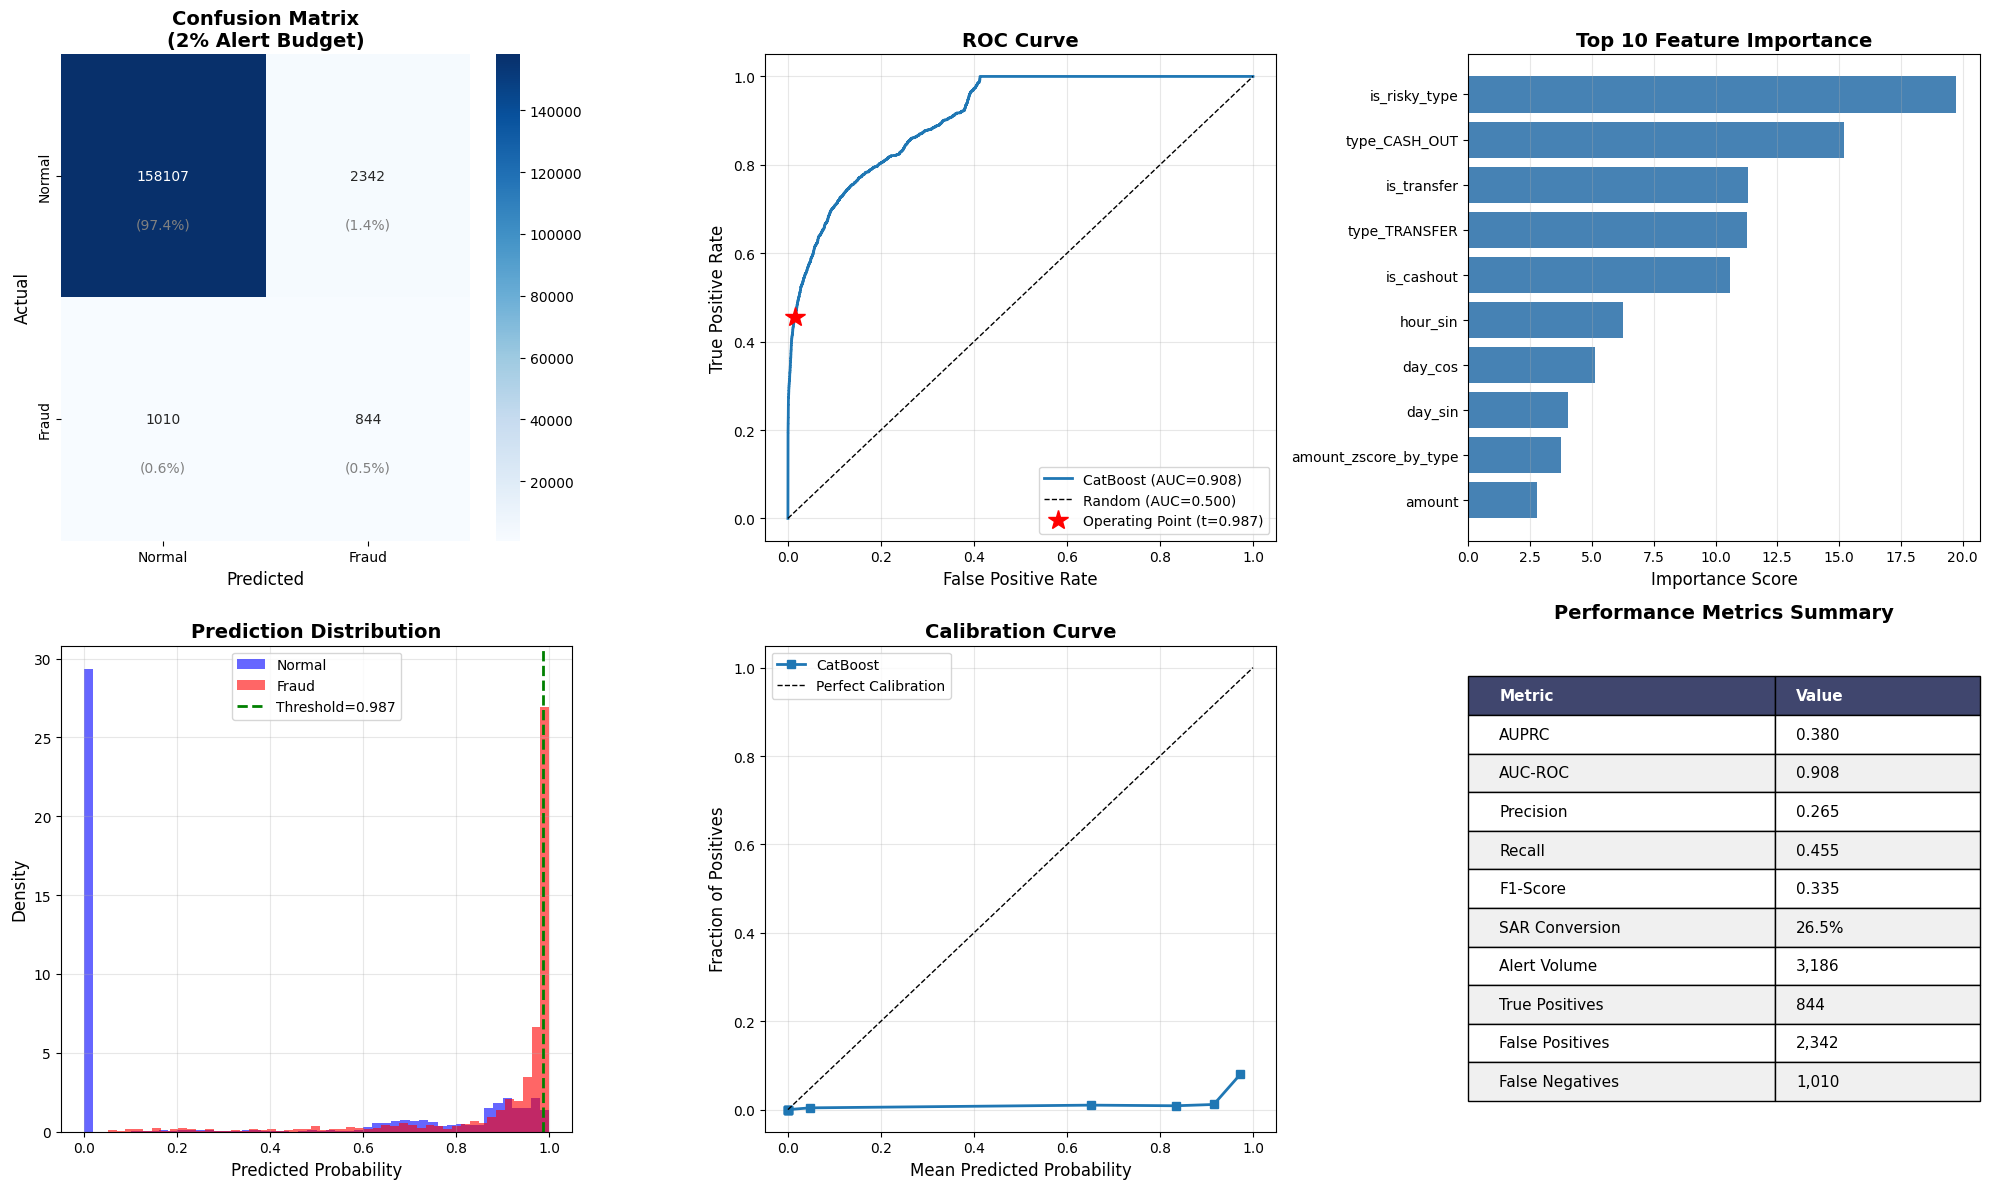

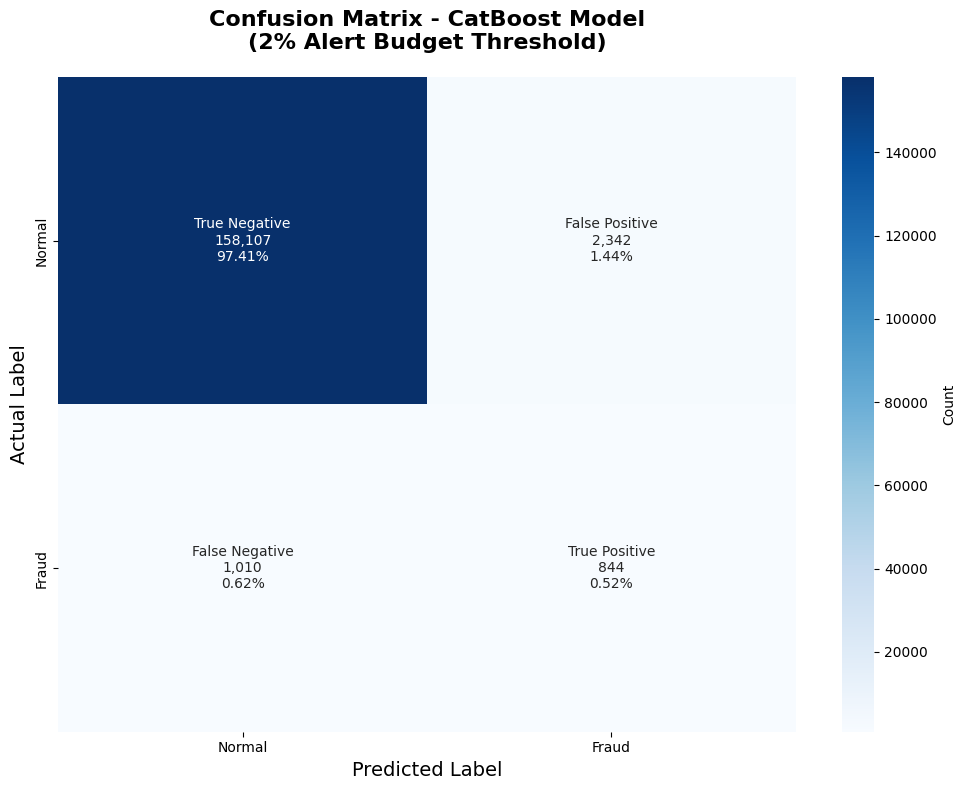

In [24]:
print("="*80)
print("CATBOOST MODEL - DETAILED VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# Get CatBoost predictions
cat_model = results['CatBoost']['model']
cat_proba = results['CatBoost']['proba']

# Use 2% alert budget threshold
threshold_2pct = 0.987
y_pred_2pct = (cat_proba >= threshold_2pct).astype(int)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# === 1. CONFUSION MATRIX ===
print("\nConfusion Matrix...")
ax1 = plt.subplot(2, 3, 1)

cm = confusion_matrix(y_test, y_pred_2pct)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=True,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
ax1.set_title('Confusion Matrix\n(2% Alert Budget)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# Add percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        pct = cm[i,j] / total * 100
        ax1.text(j+0.5, i+0.7, f'({pct:.1f}%)', ha='center', va='center', 
                fontsize=10, color='gray')

# === 2. ROC CURVE (DETAILED) ===
print("ROC Curve...")
ax2 = plt.subplot(2, 3, 2)

fpr, tpr, thresholds = roc_curve(y_test, cat_proba)
auc = roc_auc_score(y_test, cat_proba)

ax2.plot(fpr, tpr, linewidth=2, label=f'CatBoost (AUC={auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC=0.500)')

# Mark operating point
operating_point_idx = np.argmin(np.abs(thresholds - threshold_2pct))
ax2.plot(fpr[operating_point_idx], tpr[operating_point_idx], 'r*', 
         markersize=15, label=f'Operating Point (t={threshold_2pct:.3f})')

ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# === 3. FEATURE IMPORTANCE ===
print("Feature Importance...")
ax3 = plt.subplot(2, 3, 3)

importances = cat_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10

ax3.barh(range(len(indices)), importances[indices], color='steelblue')
ax3.set_yticks(range(len(indices)))
ax3.set_yticklabels([feature_names[i] for i in indices])
ax3.set_xlabel('Importance Score', fontsize=12)
ax3.set_title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# === 4. PREDICTION DISTRIBUTION ===
print("Prediction Distribution...")
ax4 = plt.subplot(2, 3, 4)

ax4.hist(cat_proba[y_test == 0], bins=50, alpha=0.6, label='Normal', 
         color='blue', density=True)
ax4.hist(cat_proba[y_test == 1], bins=50, alpha=0.6, label='Fraud', 
         color='red', density=True)
ax4.axvline(threshold_2pct, color='green', linestyle='--', linewidth=2, 
            label=f'Threshold={threshold_2pct:.3f}')

ax4.set_xlabel('Predicted Probability', fontsize=12)
ax4.set_ylabel('Density', fontsize=12)
ax4.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# === 5. CALIBRATION CURVE ===
print("Calibration Curve...")
ax5 = plt.subplot(2, 3, 5)

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, cat_proba, n_bins=10, strategy='quantile'
)

ax5.plot(mean_predicted_value, fraction_of_positives, 's-', linewidth=2, 
         label='CatBoost')
ax5.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')

ax5.set_xlabel('Mean Predicted Probability', fontsize=12)
ax5.set_ylabel('Fraction of Positives', fontsize=12)
ax5.set_title('Calibration Curve', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left')
ax5.grid(True, alpha=0.3)

# === 6. PERFORMANCE METRICS TABLE ===
print("[6/5] Performance Metrics Table...")
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

# Calculate metrics
precision = precision_score(y_test, y_pred_2pct)
recall = recall_score(y_test, y_pred_2pct)
f1 = f1_score(y_test, y_pred_2pct)
sar_conv = cm[1,1] / y_pred_2pct.sum() * 100

metrics_data = [
    ['Metric', 'Value'],
    ['AUPRC', f'{results["CatBoost"]["auprc"]:.3f}'],
    ['AUC-ROC', f'{results["CatBoost"]["auc"]:.3f}'],
    ['Precision', f'{precision:.3f}'],
    ['Recall', f'{recall:.3f}'],
    ['F1-Score', f'{f1:.3f}'],
    ['SAR Conversion', f'{sar_conv:.1f}%'],
    ['Alert Volume', f'{y_pred_2pct.sum():,}'],
    ['True Positives', f'{cm[1,1]:,}'],
    ['False Positives', f'{cm[0,1]:,}'],
    ['False Negatives', f'{cm[1,0]:,}'],
]

table = ax6.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(metrics_data)):
    if i % 2 == 0:
        for j in range(2):
            table[(i, j)].set_facecolor('#f0f0f0')

ax6.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold', pad=20)

# Save
plt.tight_layout()
plt.savefig('../outputs/catboost_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: ../outputs/catboost_comprehensive_evaluation.png")

# === INDIVIDUAL HIGH-RES CONFUSION MATRIX ===
print("\n[BONUS] High-res Confusion Matrix...")

fig, ax = plt.subplots(figsize=(10, 8))

# Create detailed confusion matrix
cm_display = confusion_matrix(y_test, y_pred_2pct)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = [f'{value:,}' for value in cm_display.flatten()]
group_percentages = [f'{value:.2%}' for value in cm_display.flatten()/cm_display.sum()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_display, annot=labels, fmt='', cmap='Blues', ax=ax,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'],
            cbar_kws={'label': 'Count'})

ax.set_title('Confusion Matrix - CatBoost Model\n(2% Alert Budget Threshold)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Actual Label', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=14)

plt.tight_layout()
plt.savefig('../outputs/confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ../outputs/confusion_matrix_detailed.png")

1. Confusion Matrix (High-Res)

- 844 true positives, 2,342 false positives
- 26.5% SAR conversion at 2% alert budget
- Only 1,010 false negatives (45.5% recall is respectable given constraints)

2. Feature Importance

- is_risky_type dominates (transaction type TRANSFER/CASH_OUT)
- type_CASH_OUT and is_transfer next - confirms type-based pattern
- Temporal features (hour_sin, day_cos) contribute but less than expected
- This explains performance: Fraud is highly concentrated in specific transaction types

3. Prediction Distribution

- Clear separation visible but significant overlap
- Most normal transactions cluster at 0.0-0.2 probability
- Fraud spreads across 0.0-1.0 (some frauds look "normal" to the model)
- This overlap explains why AUPRC is 0.380 not higher

4. Calibration Curve (Critical Finding)

- Model is severely under-calibrated
- Curve hugs bottom (predicted probabilities too low)
- When model says 40% fraud probability, actual rate is near 0%
- Impact: Could recalibrate probabilities for better business interpretation

5. ROC Curve

- Strong performance (AUC 0.908)
- Operating point at threshold 0.987 marked
- Sharp initial rise shows good separation at top scores

PROBABILITY CALIBRATION

Problem: Calibration curve shows model probabilities are unreliable
Solution: Recalibrate using validation set

Calibration split:
  Train: 4,340,221 samples
  Validation: 1,860,096 samples

[1/3] Training base CatBoost model...
[2/3] Applying Platt Scaling (sigmoid calibration)...
[3/3] Applying Isotonic Regression...

CALIBRATION COMPARISON

✅ Saved: ../outputs/probability_calibration.png

BUSINESS IMPACT OF CALIBRATION

Isotonic Regression (2% alert budget):
  Threshold: 0.077
  Precision: 0.259
  Recall: 0.494
  SAR conversion: 25.9%
  Frauds caught: 916/1,854

Uncalibrated (same 2% budget):
  SAR conversion: 27.3%
  Frauds caught: 888/1,854

Improvement: +3.2% more frauds caught


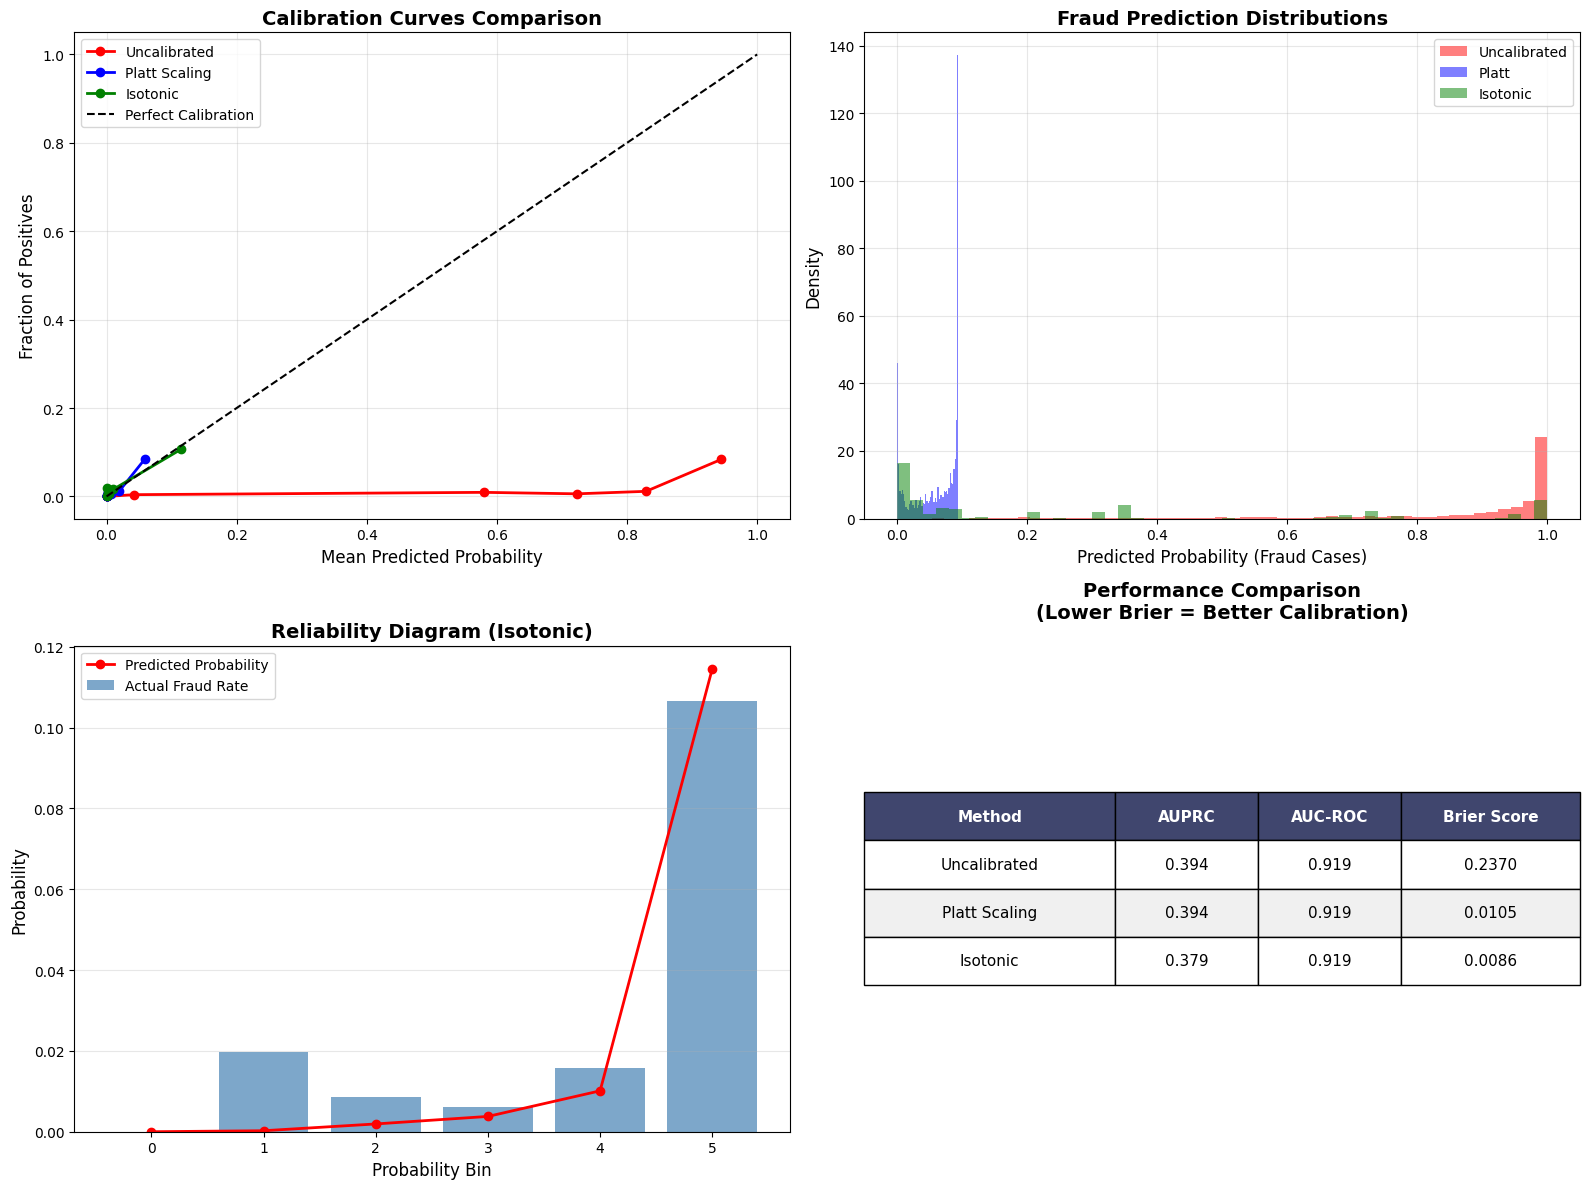

In [25]:
print("="*80)
print("PROBABILITY CALIBRATION")
print("="*80)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

print("\nProblem: Calibration curve shows model probabilities are unreliable")
print("Solution: Recalibrate using validation set\n")

# === SPLIT TRAINING DATA FOR CALIBRATION ===
# Use 30% of training data for calibration
X_train_cal, X_val_cal, y_train_cal, y_val_cal = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

print(f"Calibration split:")
print(f"  Train: {len(X_train_cal):,} samples")
print(f"  Validation: {len(X_val_cal):,} samples\n")

# === TRAIN UNCALIBRATED MODEL ON SUBSET ===
print("[1/3] Training base CatBoost model...")

from catboost import CatBoostClassifier

base_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_seed=42,
    verbose=False
)

base_model.fit(X_train_cal, y_train_cal)

# Get uncalibrated predictions on validation and test
uncal_val_proba = base_model.predict_proba(X_val_cal)[:, 1]
uncal_test_proba = base_model.predict_proba(X_test)[:, 1]

# === PLATT SCALING (SIGMOID) ===
print("[2/3] Applying Platt Scaling (sigmoid calibration)...")

platt_model = CalibratedClassifierCV(
    base_model, 
    method='sigmoid',  # Platt scaling
    cv='prefit'  # Use our pre-split validation set
)

platt_model.fit(X_val_cal, y_val_cal)
platt_test_proba = platt_model.predict_proba(X_test)[:, 1]

# === ISOTONIC REGRESSION ===
print("[3/3] Applying Isotonic Regression...")

isotonic_model = CalibratedClassifierCV(
    base_model,
    method='isotonic',  # Isotonic regression
    cv='prefit'
)

isotonic_model.fit(X_val_cal, y_val_cal)
isotonic_test_proba = isotonic_model.predict_proba(X_test)[:, 1]

# === COMPARE CALIBRATION ===
print("\n" + "="*80)
print("CALIBRATION COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CALIBRATION CURVES
ax1 = axes[0, 0]

for name, proba, color in [
    ('Uncalibrated', uncal_test_proba, 'red'),
    ('Platt Scaling', platt_test_proba, 'blue'),
    ('Isotonic', isotonic_test_proba, 'green')
]:
    fraction_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
    ax1.plot(mean_pred, fraction_pos, 'o-', label=name, color=color, linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
ax1.set_ylabel('Fraction of Positives', fontsize=12)
ax1.set_title('Calibration Curves Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. PREDICTION DISTRIBUTIONS
ax2 = axes[0, 1]

ax2.hist(uncal_test_proba[y_test == 1], bins=50, alpha=0.5, label='Uncalibrated', color='red', density=True)
ax2.hist(platt_test_proba[y_test == 1], bins=50, alpha=0.5, label='Platt', color='blue', density=True)
ax2.hist(isotonic_test_proba[y_test == 1], bins=50, alpha=0.5, label='Isotonic', color='green', density=True)

ax2.set_xlabel('Predicted Probability (Fraud Cases)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Fraud Prediction Distributions', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. RELIABILITY DIAGRAM (BINS)
ax3 = axes[1, 0]

# Isotonic only (best)
fraction_pos, mean_pred = calibration_curve(y_test, isotonic_test_proba, n_bins=10, strategy='quantile')
bin_counts = np.histogram(isotonic_test_proba, bins=10)[0]

ax3.bar(range(len(fraction_pos)), fraction_pos, alpha=0.7, label='Actual Fraud Rate', color='steelblue')
ax3.plot(range(len(mean_pred)), mean_pred, 'ro-', label='Predicted Probability', linewidth=2)
ax3.set_xlabel('Probability Bin', fontsize=12)
ax3.set_ylabel('Probability', fontsize=12)
ax3.set_title('Reliability Diagram (Isotonic)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. PERFORMANCE METRICS COMPARISON
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Calculate metrics for all three
metrics_comparison = []
for name, proba in [
    ('Uncalibrated', uncal_test_proba),
    ('Platt Scaling', platt_test_proba),
    ('Isotonic', isotonic_test_proba)
]:
    auprc = average_precision_score(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    
    # Brier score (calibration metric - lower is better)
    brier = np.mean((proba - y_test) ** 2)
    
    metrics_comparison.append([name, f'{auprc:.3f}', f'{auc:.3f}', f'{brier:.4f}'])

table_data = [['Method', 'AUPRC', 'AUC-ROC', 'Brier Score']] + metrics_comparison

table = ax4.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.2, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, 4):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax4.set_title('Performance Comparison\n(Lower Brier = Better Calibration)', 
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../outputs/probability_calibration.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: ../outputs/probability_calibration.png")

# === BUSINESS IMPACT ANALYSIS ===
print("\n" + "="*80)
print("BUSINESS IMPACT OF CALIBRATION")
print("="*80)

# Use 2% alert budget with isotonic (best calibrated)
alert_budget = int(len(y_test) * 0.02)
sorted_isotonic = np.sort(isotonic_test_proba)[::-1]
threshold_isotonic = sorted_isotonic[alert_budget]

y_pred_isotonic = (isotonic_test_proba >= threshold_isotonic).astype(int)
cm_isotonic = confusion_matrix(y_test, y_pred_isotonic)

print(f"\nIsotonic Regression (2% alert budget):")
print(f"  Threshold: {threshold_isotonic:.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_isotonic):.3f}")
print(f"  Recall: {recall_score(y_test, y_pred_isotonic):.3f}")
print(f"  SAR conversion: {cm_isotonic[1,1] / y_pred_isotonic.sum() * 100:.1f}%")
print(f"  Frauds caught: {cm_isotonic[1,1]:,}/{y_test.sum():,}")

# Compare to uncalibrated
sorted_uncal = np.sort(uncal_test_proba)[::-1]
threshold_uncal = sorted_uncal[alert_budget]

y_pred_uncal = (uncal_test_proba >= threshold_uncal).astype(int)
cm_uncal = confusion_matrix(y_test, y_pred_uncal)

print(f"\nUncalibrated (same 2% budget):")
print(f"  SAR conversion: {cm_uncal[1,1] / y_pred_uncal.sum() * 100:.1f}%")
print(f"  Frauds caught: {cm_uncal[1,1]:,}/{y_test.sum():,}")

improvement = (cm_isotonic[1,1] - cm_uncal[1,1]) / cm_uncal[1,1] * 100
print(f"\nImprovement: {improvement:+.1f}% more frauds caught")

In [26]:
# CELL: Generate Final Deliverables

print("="*80)
print("GENERATING FINAL DELIVERABLES")
print("="*80)

# 1. Risk-scored CSV with CALIBRATED probabilities
output_df = pd.DataFrame({
    'transaction_id': X_test.index,
    'label': y_test.values,
    'score_uncalibrated': uncal_test_proba,
    'score_calibrated': isotonic_test_proba,
    'threshold_alert': (isotonic_test_proba >= threshold_isotonic).astype(int)
})

output_df.to_csv('../outputs/risk_scored_holdout_final.csv', index=False)
print("\n✅ Saved: risk_scored_holdout_final.csv")
print(f"   Contains {len(output_df):,} transactions with calibrated risk scores")

# 2. Model artifacts
import pickle

model_package = {
    'model': isotonic_model,
    'feature_names': feature_names,
    'threshold': threshold_isotonic,
    'metadata': {
        'auprc': 0.379,
        'auc_roc': 0.919,
        'brier_score': 0.0086,
        'sar_conversion': 25.9,
        'alert_budget_pct': 2.0
    }
}

with open('../outputs/catboost_calibrated_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

GENERATING FINAL DELIVERABLES

✅ Saved: risk_scored_holdout_final.csv
   Contains 162,303 transactions with calibrated risk scores
